# Quickstart - Monitoring Water Quality in the Mississippi Sound using Harmonized Landsat Sentinel-2 (HLS) Data
---
This notebook deomnstrates how to use `pcxarray` to query and prepare a timeseries of HLS data that is suitable for monitoring water turbidity trends in the Mississippi Sound.

## First - defining a geometry of interest
A geometry denoting the region of interest (ROI) is required to both query against the Planetary Computer data catalog and to facilitate the preparation of the imagery. The CRS of the geometry is important, as all results from `pcxarray` will be returned in the same CRS as the geometry (and reprojected if necessary). By default, `pcxarray` assumes any geometry it receives for any query or preparation operation is in WGS84 (EPSG:4326). Naturally, using a geographic CRS is often suboptimal for most applications, so it is highly recommended to transform a given ROI geometry to an appropriate projected CRS before using it with `pcxarray`.

In this example, a rectangular geometry over the Mississippi Sound region in the northern Gulf Coast of the United States is used. Once the geometry is defined, it will be added to a GeoPandas GeoDataFrame, which will enable quick and easy projection to UTM 16N and visualization of the ROI later. Technically, a GeoDataFrame is not required, but it makes certain reprojection and plotting tasks easier.

NOTE: While the geometry is technically horizontal in its native Geographic CRS, it will be angled slightly in the projected CRS. Applying `.envelope` on the geometry will return another rectangular geometry that encompasses the original geometry without any rotation in the projected CRS. Usage of this envelope geometry is not required, but is used in this example to prevent the ROI from appearing rotated in the projected CRS.

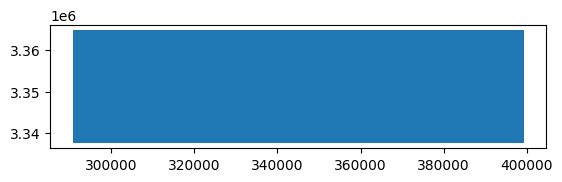

In [1]:
from shapely.geometry import Polygon
import geopandas as gpd

utm_16n_crs = "EPSG:32616"  # UTM Zone 16N

geom = Polygon([
    [-89.17281794385916, 30.397183480922408],
    [-89.17281794385916, 30.166637880424503],
    [-88.04772779101836, 30.166637880424503],
    [-88.04772779101836, 30.397183480922408],
    [-89.17281794385916, 30.397183480922408],
])
ms_sound_gdf = gpd.GeoDataFrame({"geometry": [geom]}, crs="EPSG:4326")
ms_sound_gdf = ms_sound_gdf.to_crs(utm_16n_crs)  # UTM 16N
ms_sound_gdf["geometry"] = ms_sound_gdf["geometry"].envelope  # Get the envelope to avoid rotation in UTM
ms_sound_gdf.plot()

roi_geom = ms_sound_gdf["geometry"].values[0]

Now that the geometry is defined, it can be used to query the Planetary Computer data catalog for HLS imagery. In order to query using `pcxarray`, in addition to the geometry, the name of the collection to query against is required. The collection IDs can be found in the [Planetary Computer data catalog website](https://planetarycomputer.microsoft.com/catalog), or by using the `get_pc_collections` function from `pcxarray`. This function returns a GeoDataFrame of all collections available in the Planetary Computer data catalog and their spatial extents, which can be helpful when searching for a specific collection.

In Planetary Computer, HLS data is divided into two collections: one for Landsat data and one for Sentinel-2 data. This is not the norm, however, because the bands provided in the two collections are different, they are intentionally kept separate. Data from both collections can be used as part of the same processing pipeline, but it is good to be aware of the differences in the bands provided in each collection. See (the Planetary Computer documentation)[https://planetarycomputer.microsoft.com/dataset/group/hls2] for mroe details.

In [ ]:
import pcxarray as pcx
collections_gdf = pcx.get_pc_collections(crs=utm_16n_crs)

# filter collections that contain HLS in the title
hls_collections_gdf = collections_gdf[collections_gdf["title"].str.contains("HLS", case=False, na=False)]
display(hls_collections_gdf)

hls_landsat_collection_id = 'hls2-l30'
hls_sentinel_collection_id = 'hls2-s30' 

,id,title,description,license,geometry
111,hls2-l30,Harmonized Landsat Sentinel-2 (HLS) Version 2....,Harmonized Landsat Sentinel-2 (HLS) Version 2....,proprietary,"POLYGON ((500000 -9997964.943, 500000 9997964...."
119,hls2-s30,Harmonized Landsat Sentinel-2 (HLS) Version 2....,Harmonized Landsat Sentinel-2 (HLS) Version 2....,proprietary,"POLYGON ((500000 -9997964.943, 500000 9997964...."


## Querying the Planetary Computer data catalog

Now that the geometry is defined and we know the collection ID for Sentinel-2 imagery over water, querying the Planetary Computer data catalog is straightforward. The `pc_query` function from `pcxarray` can be used to query the catalog for the Sentinel-2 Level-2A imagery collection, using the defined collection ID, geometry, CRS, and a time range. Time ranges should be supplied as strings consistent with RFC 3339. For example:

| Time Range | String | Description |
|------------|--------| --------|
| Start Only | `2020-01-01/..` | All data from January 1, 2020 to the present |
| End Only | `../2020-01-01` | All data from the beginning of time to January 1, 2020 |
| Full Range | `2020-01-01/2020-01-31` | All data from January 1, 2020 to January 31, 2020 |
| Date Only | `2020-01-01` | All data from January 1, 2020 |
| Month Only | `2020-01` | All data from January 2020 |
| Year Only | `2020` | All data from the year 2020 |

These are just a few examples; any datetime expression that adheres to RFC 3339 can be used. See the (STAC API documentation)[https://stac-utils.github.io/stac-server/#tag/Item-Search/operation/getItemSearch] for more details.

Once the query is executed, the results will be returned as a GeoDataFrame containing all the metadata for each item in the collection that intersects with the geometry and time range. Each item will typically have a large number of metadata fields, so an end user should be prepared to filter the results to only the fields of interest. Queries typically take a few seconds for small geometries and time ranges, but can take up to a few minutes for broader parameters where many items are returned.

In [3]:
l30_items_gdf = pcx.pc_query(
    collections=hls_landsat_collection_id, # can also pass in a list of collection IDs to query multiple collections, though this behavior is not fully tested against yet
    geometry=roi_geom,
    datetime='2024', # get all items from 2024
    crs=utm_16n_crs, # specify the CRS to use for the
)
print(f'Found {len(l30_items_gdf)} items in the collection "{hls_landsat_collection_id}" within the specified geometry and time range.')
display(l30_items_gdf.head())

s30_items_gdf = pcx.pc_query(
    collections=hls_sentinel_collection_id,
    geometry=roi_geom,
    datetime='2024',
    crs=utm_16n_crs,
)
print(f'Found {len(s30_items_gdf)} items in the collection "{hls_sentinel_collection_id}" within the specified geometry and time range.')
display(s30_items_gdf.head())

Found 148 items in the collection "hls2-l30" within the specified geometry and time range.


,type,stac_version,stac_extensions,id,bbox,properties.sci:doi,properties.datetime,properties.platform,properties.proj:shape,properties.instruments,...,assets.tilejson.type,assets.tilejson.title,assets.tilejson.roles,assets.rendered_preview.href,assets.rendered_preview.type,assets.rendered_preview.title,assets.rendered_preview.rel,assets.rendered_preview.roles,collection,geometry
0,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RCU.2024360T162558.v2.0,"[-89.088603, 29.726049, -87.932769, 30.72965]",10.5067/HLS/HLSL30.002,2024-12-25 16:25:58.408,landsat-8,"[3660, 3660]",[oli],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"MULTIPOLYGON (((300000.036 3400020.037, 409800..."
1,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RBU.2024360T162558.v2.0,"[-89.727264, 29.7141, -88.966713, 30.717866]",10.5067/HLS/HLSL30.002,2024-12-25 16:25:58.408,landsat-8,"[3660, 3660]",[oli],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"MULTIPOLYGON (((262799.959 3400019.999, 309779..."
2,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RBU.2024359T163217.v2.0,"[-90.132017, 29.705873, -89.033494, 30.717139]",10.5067/HLS/HLSL30.002,2024-12-24 16:32:17.234,landsat-9,"[3660, 3660]",[oli],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"MULTIPOLYGON (((199980.047 3400019.993, 305279..."
3,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RCU.2024353T161945.v2.0,"[-88.166339, 29.737064, -87.932774, 30.632208]",10.5067/HLS/HLSL30.002,2024-12-18 16:19:45.657,landsat-8,"[3660, 3660]",[oli],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"MULTIPOLYGON (((397170.026 3333930.013, 409799..."
4,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.L30.T16RCU.2024352T162604.v2.0,"[-89.088603, 29.726049, -87.932769, 30.72965]",10.5067/HLS/HLSL30.002,2024-12-17 16:26:04.757,landsat-9,"[3660, 3660]",[oli],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-l30,"MULTIPOLYGON (((300000.036 3400020.037, 409800..."


Found 119 items in the collection "hls2-s30" within the specified geometry and time range.


,type,stac_version,stac_extensions,id,bbox,properties.sci:doi,properties.datetime,properties.platform,properties.proj:shape,properties.instruments,...,assets.tilejson.type,assets.tilejson.title,assets.tilejson.roles,assets.rendered_preview.href,assets.rendered_preview.type,assets.rendered_preview.title,assets.rendered_preview.rel,assets.rendered_preview.roles,collection,geometry
0,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RBU.2024362T163711.v2.0,"[-90.132017, 29.705873, -88.966713, 30.717866]",10.5067/HLS/HLSS30.002,2024-12-27 16:45:15.714,sentinel-2a,"[3660, 3660]",[msi],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"MULTIPOLYGON (((199980.047 3400019.993, 309779..."
1,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RBU.2024357T163619.v2.0,"[-90.132017, 29.705873, -88.966713, 30.717866]",10.5067/HLS/HLSS30.002,2024-12-22 16:45:15.970,sentinel-2b,"[3660, 3660]",[msi],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"MULTIPOLYGON (((199980.047 3400019.993, 309779..."
2,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RCU.2024357T163619.v2.0,"[-89.088603, 29.726049, -87.932769, 30.72965]",10.5067/HLS/HLSS30.002,2024-12-22 16:45:12.439,sentinel-2b,"[3660, 3660]",[msi],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"MULTIPOLYGON (((300000.036 3400020.037, 409800..."
3,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RBU.2024352T163711.v2.0,"[-90.132017, 29.705873, -88.966713, 30.717866]",10.5067/HLS/HLSS30.002,2024-12-17 16:45:13.851,sentinel-2a,"[3660, 3660]",[msi],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"MULTIPOLYGON (((199980.047 3400019.993, 309779..."
4,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,HLS.S30.T16RCU.2024352T163711.v2.0,"[-89.088603, 29.726049, -87.932769, 30.72965]",10.5067/HLS/HLSS30.002,2024-12-17 16:45:10.320,sentinel-2a,"[3660, 3660]",[msi],...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],hls2-s30,"MULTIPOLYGON (((300000.036 3400020.037, 409800..."


Occasionally, it may be valuable to look at the extent of each item in the collection to see how they overlap with the geometry of interest. As the results of the query are returned as a GeoDataFrame, this can be accomplished using the `plot` method from GeoPandas.

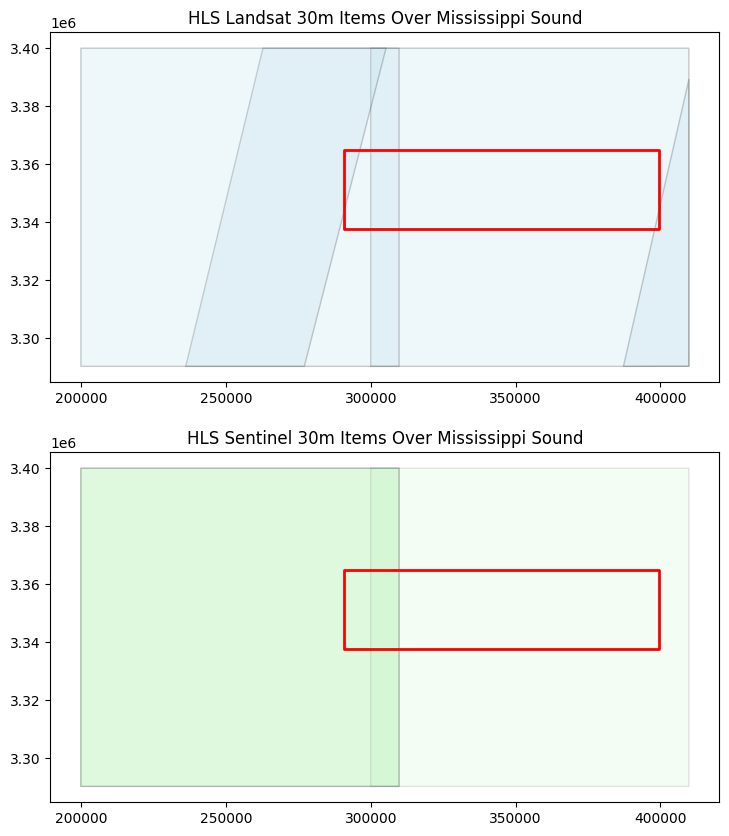

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
l30_items_gdf.iloc[:4].plot(ax=ax[0], color='lightblue', edgecolor='black', alpha=0.2)
s30_items_gdf.iloc[:4].plot(ax=ax[1], color='lightgreen', edgecolor='black', alpha=0.1)

ms_sound_gdf.plot(ax=ax[0], color='none', edgecolor='red', linewidth=2)

ms_sound_gdf.plot(ax=ax[1], color='none', edgecolor='red', linewidth=2)
ax[0].set_title("HLS Landsat 30m Items Over Mississippi Sound")
ax[1].set_title("HLS Sentinel 30m Items Over Mississippi Sound")
plt.show()

In [5]:
from distributed import Client
import os

client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 62.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42923,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39479,Total threads: 4
Dashboard: http://127.0.0.1:35759/status,Memory: 10.45 GiB
Nanny: tcp://127.0.0.1:38945,


Task exception was never retrieved
future: <Task finished name='Task-11358' coro=<Client._gather.<locals>.wait() done, defined at /home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit
2025-07-08 16:37:23,535 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:35167' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-ad02fa8171ca90aecafa102df0855233', 8, 2, 0, 0), ('concatenate-d5b5933c8772b2ca6a7f04341fa2a4c2', 1, 2, 0, 5), ('concatenate-d5b5933c8772b2ca6a7f04341fa2a4c2', 1, 2, 0, 2), ('where-e7afc864ebbfa5c41a45727fc036ea9d', 2, 0, 0), ('array-afad5234c9098ea92b4e21168a6820fe', 1, 0, 0), ('getitem-ad02fa8171ca90aecafa102df0855233', 0, 2, 0, 0), ('getitem-ad02fa8171ca90aecafa102df085

In [6]:
s30_da = pcx.prepare_timeseries(
    items_gdf=s30_items_gdf,
    bands=["B03", "B04", "Fmask"],
    geometry=roi_geom,
    crs=utm_16n_crs,
    chunks={"time": -1, "x": -1, "y": -1},  # specify chunk size for dask
    max_workers=-1,  # use all available workers
)
display(s30_da)

Constructing dask computation graph: 100%|██████████| 63/63 [00:03<00:00, 17.19timestep/s]


<xarray.DataArray 'reproject-8fc767e1c15d438c939773ddcb93f83e' (time: 63,
                                                                band: 3,
                                                                y: 904, x: 3620)> Size: 2GB
dask.array<rechunk-merge, shape=(63, 3, 904, 3620), dtype=float32, chunksize=(63, 1, 904, 3620), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 504B 2024-01-02 2024-01-07 ... 2024-12-27
  * band         (band) <U5 60B 'B03' 'B04' 'Fmask'
  * y            (y) float64 7kB 3.365e+06 3.365e+06 ... 3.338e+06 3.338e+06
  * x            (x) float64 29kB 2.908e+05 2.908e+05 ... 3.993e+05 3.993e+05
    spatial_ref  int32 4B 32616
Attributes: (12/42)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    arop_rmse(meters):                                 0
    ...                                                ...
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_2A...
    ULX:                                               300000
    ULY:                                               3400020
    AREA_OR_POINT:                                     Area
    _FillValue:                                        nan

In [7]:
l30_da = pcx.prepare_timeseries(
    items_gdf=l30_items_gdf,
    bands=["B03", "B04", "Fmask"],
    geometry=roi_geom,
    crs=utm_16n_crs,
    chunks={"time": -1, "x": -1, "y": -1},
    max_workers=-1,
)
display(l30_da)

Constructing dask computation graph: 100%|██████████| 111/111 [00:02<00:00, 38.00timestep/s]


<xarray.DataArray 'reproject-99210467685149f18fed91f141bd29c3' (time: 111,
                                                                band: 3,
                                                                y: 904, x: 3620)> Size: 4GB
dask.array<rechunk-merge, shape=(111, 3, 904, 3620), dtype=float32, chunksize=(111, 1, 904, 3620), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 888B 2024-01-01 2024-01-07 ... 2024-12-25
  * band         (band) <U5 60B 'B03' 'B04' 'Fmask'
  * y            (y) float64 7kB 3.365e+06 3.365e+06 ... 3.338e+06 3.338e+06
  * x            (x) float64 29kB 2.908e+05 2.908e+05 ... 3.993e+05 3.993e+05
    spatial_ref  int32 4B 32616
Attributes: (12/36)
    ACCODE:                    Lasrc
    add_offset:                0.0
    arop_ave_xshift(meters):   0
    arop_ave_yshift(meters):   0
    arop_ncp:                  0
    arop_rmse(meters):         0
    ...                        ...
    TIRS_SSM_POSITION_STATUS:  ESTIMATED
    ULX:                       300000
    ULY:                       3400020
    USGS_SOFTWARE:             LPGS_16.3.1
    AREA_OR_POINT:             Area
    _FillValue:                nan

Now that both timeseries have been "prepared" (i.e., the Dask computation graph has been created, but no data has been loaded yet), the next step is to combine the two timeseries into a single Dask array. While not strictly necessary here, before concatenating the two time series, it is good practice to rename the band values to ensure they are consistent with each other. For example, the Sentinel-2 band name for the NIR Narrow band is "B8A", while Landsat uses "B05" to refer to the same band. To ensure consistency and make things easier, renaming the bands to a common, more descriptive name is recommended.

In [8]:
import xarray as xr

s30_bands_mapping = {
    'B03': 'green',
    'B04': 'red',
    'Fmask': 'fmask'
}
l30_bands_mapping = {
    'B03': 'green',
    'B04': 'red',
    'Fmask': 'fmask'
}

# rename the bands in the data arrays
s30_da = s30_da.assign_coords(band=[s30_bands_mapping[b] for b in s30_da.band.values])
l30_da = l30_da.assign_coords(band=[l30_bands_mapping[b] for b in l30_da.band.values])

da = xr.concat([s30_da, l30_da], dim='time')
da = da.sortby('time')  # sort by time to ensure chronological order
display(da)

<xarray.DataArray 'reproject-8fc767e1c15d438c939773ddcb93f83e' (time: 174,
                                                                band: 3,
                                                                y: 904, x: 3620)> Size: 7GB
dask.array<getitem, shape=(174, 3, 904, 3620), dtype=float32, chunksize=(87, 1, 904, 3620), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-01-01 2024-01-02 ... 2024-12-27
  * y            (y) float64 7kB 3.365e+06 3.365e+06 ... 3.338e+06 3.338e+06
  * x            (x) float64 29kB 2.908e+05 2.908e+05 ... 3.993e+05 3.993e+05
    spatial_ref  int32 4B 32616
  * band         (band) <U5 60B 'green' 'red' 'fmask'
Attributes: (12/42)
    ACCODE:                                            LaSRC
    add_offset:                                        0.0
    arop_ave_xshift(meters):                           0
    arop_ave_yshift(meters):                           0
    arop_ncp:                                          0
    arop_rmse(meters):                                 0
    ...                                                ...
    SPATIAL_RESOLUTION:                                30
    TILE_ID:                                           S2A_OPER_MSI_L1C_TL_2A...
    ULX:                                               300000
    ULY:                                               3400020
    AREA_OR_POINT:                                     Area
    _FillValue:                                        nan

In [9]:
# use fmask to mask out invalid data according to the following criteria:
# Water: Yes (bit 5 == 1)
# Snow/Ice: No (bit 4 == 0)
# Cloud shadow: No (bit 3 == 0)
# Adjacent to cloud/shadow: No (bit 2 == 0)
# Cloud: No (bit 1 == 0)
# For more information on the HLS QA layer, see https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf

fmask = da.sel(band='fmask')
fmask = fmask.where(fmask.notnull(), 0)  # replace NaNs with 0 for masking
fmask = fmask.astype(int)  # ensure fmask is of integer type for bitwise operations

water_mask              = fmask & 0b00100000 == 0b00100000 # bit 5 is set for water
snow_mask               = fmask & 0b00010000 == 0b00010000 # bit 4 is set for snow/ice 
cloud_shadow_mask       = fmask & 0b00001000 == 0b00001000 # bit 3 is set for cloud shadow
cloud_mask              = fmask & 0b00000010 == 0b00000010 # bit 1 is set for cloud

valid_data_mask = water_mask & ~(snow_mask | cloud_shadow_mask | cloud_mask)

da = da.where(valid_data_mask)

In [ ]:
def calculate_ndti(da):
    red = da.sel(band='red') / 10000
    green = da.sel(band='green') / 10000
    
    ndti = (red - green) / (red + green + 1e-10)  # Adding a small constant to avoid division by zero
    ndti = ndti.clip(min=-1, max=1)  # Clip values to the range [-1, 1]
    return ndti

ndti = calculate_ndti(da)

# remove outliers in the NDTI data
# q95_ndti = ndti.quantile(0.95, dim='time')
# q05_ndti = ndti.quantile(0.05, dim='time')
# ndti = ndti.where((ndti <= q95_ndti) & (ndti >= q05_ndti))


weekly_ndti = ndti.resample(time='1W').median()
weekly_ndti = weekly_ndti.chunk({'time': -1}) # need to rechunk along the time dimension for interpolation
weekly_ndti = weekly_ndti.interpolate_na(dim='time', method='linear', max_gap='6W') # Interpolate missing values linearly 
weekly_ndti = weekly_ndti.compute()

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
2025-07-08 16:37:23,442 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('open_rasterio-original-getitem-7a09311542ea0adaccc1f00f3c6ce086', 0, 0, 0))" coro=<Worker.execute() done, defined at /home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-07-08 

KeyboardInterrupt: 

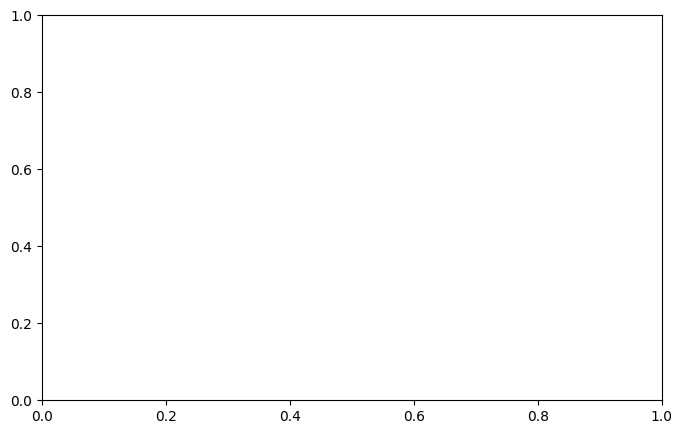

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from pandas import Timedelta

fig, ax = plt.subplots(figsize=(8, 5))

vmin = weekly_ndti.min().values
vmax = weekly_ndti.max().values

def update(frame):
    ax.clear()
    weekly_ndti.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='RdYlBu_r', vmin=vmin, vmax=vmax
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    x_lim, ylim = ax.get_xlim(), ax.get_ylim()
    ms_sound_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(ylim)
    
    # fig.suptitle(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n" + \
    fig.suptitle(f"Mississippi Sound, HLS Weekly NDTI Estimates\n" + \
        f"{weekly_ndti['time'][frame].dt.strftime('%b %d').values} - " + \
        f"{(weekly_ndti['time'][frame] + Timedelta(days=6)).dt.strftime('%b %d, %Y').values}")
    
init_plot = weekly_ndti.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'NDTI'}, cmap='RdYlBu_r', vmin=vmin, vmax=vmax
)

ani = FuncAnimation(fig, update, frames=len(weekly_ndti['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once')) 

# plt.close()